# Gene Expression Analysis

In [2]:
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.stats import ttest_rel
from tqdm import tqdm

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
)

In [3]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_DB = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

# Gene Expression Datas
expression_file_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/Connelly2022_AxH_Pdam.counts"
deg_file_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/Connelly2022_SupplementaryData.xlsx"

# Output paths
prot_deg_cytoscape_table = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_proteins.deg.tsv"
clust_deg_cytoscape_table = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.deg.tsv"

IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/pdam")

---

## Load Files

In [4]:
cluster_dict = load_cluster_json(cluster_file_path)
go_database = parse_GO_database(GO_DB)
full_G = nx.read_weighted_edgelist(network_file_path, delimiter="\t")

In [5]:
deg_df = pd.read_excel(
    deg_file_path,
    sheet_name="Table_S4A_DEGs_coral",
    header=1,
    index_col=0,
).rename(
    {
        "DE_Heat": "DE_Heat_control",
        "DE_Antibiotics": "DE_Antibiotics_control",
        "DE_Antibiotics.Heat": "DE_Antibiotics.Heat_control",
    },
    axis=1,
)
deg_df.index = deg_df.index + "-RA"

In [6]:
expression_df = pd.read_csv(expression_file_path, sep="\t", skiprows=1)
expression_df.columns = [i.split("/")[-1].split("_")[0] for i in expression_df.columns]
expression_df["Geneid"] = expression_df["Geneid"] + "-RA"
expression_df = expression_df.set_index("Geneid")
expression_df = expression_df.iloc[:, 5:]

---

## Raw Expression

In [7]:
philharmonic_proteins = set.union(
    *[
        set(i["members"] + list(i["recipe"]["degree"]["0.75"]))
        for i in cluster_dict.values()
    ]
)
expression_philharmonic = expression_df.loc[
    expression_df.index.intersection(philharmonic_proteins)
]

In [8]:
logger.info(f"Expression data has shape: {expression_philharmonic.shape}")
expression_philharmonic.head()

2024-12-20 15:25:46.538 | INFO     | __main__:<module>:1 - Expression data has shape: (7242, 47)


,Hw1-1a,Hw1-1b,Hw1-1c,Hw1-4a,Hw1-4b,Hw1-4c,Hw1-5a,Hw1-5b,Hw1-5c,Hw1-6a,...,Wt2-1c,Wt2-4a,Wt2-4b,Wt2-4c,Wt2-5a,Wt2-5b,Wt2-5c,Wt2-6a,Wt2-6b,Wt2-6c
Geneid,,,,,,,,,,,,,,,,,,,,,
pdam_00021773-RA,292,72,77,26,8,37,353,51,271,380,...,6,5,34,16,30,23,2,28,13,25
pdam_00022011-RA,1,10,6,8,15,7,17,27,10,18,...,17,23,74,101,47,31,39,67,74,79
pdam_00012251-RA,925,1950,1260,624,1104,1154,2973,1975,1960,2170,...,1215,1117,1905,1670,1574,1933,1502,1813,1460,1686
pdam_00012254-RA,110,278,197,159,164,253,362,523,424,356,...,370,334,618,514,577,550,353,715,347,502
pdam_00012261-RA,5,7,26,30,26,14,68,103,50,46,...,104,30,188,279,156,203,100,273,246,185


Following Connelly et al., we apply a variance-stabilizing transformation to expression counts, then compute the pairwise bi-weighted mid-correlation between genes.

In [9]:
def vst(counts, alpha=1):
    """
    Apply a variance stabilizing transformation to count data.

    Parameters:
    counts (array-like): The input count data
    alpha (float): A small constant to avoid taking log of zero

    Returns:
    numpy.ndarray: The transformed data
    """
    counts = np.asarray(counts)
    return np.log2(counts + np.sqrt(counts + alpha**2))


def bicor_matrix(X, epsilon=1e-12):
    """
    Compute pairwise bi-weight mid-correlation for all genes.

    Parameters:
    X (np.ndarray): A 2D array of shape (n_genes, n_samples) containing normalized count data
    epsilon (float): Small value to avoid division by zero

    Returns:
    np.ndarray: A 2D array of shape (n_genes, n_genes) containing pairwise correlations
    """
    # Compute median and MAD for each gene
    gene_medians = np.median(X, axis=1)
    gene_mads = np.median(np.abs(X - gene_medians[:, np.newaxis]), axis=1)

    # Handle genes with zero MAD
    gene_mads = np.maximum(gene_mads, epsilon)

    # Compute U matrix
    U = (X - gene_medians[:, np.newaxis]) / (9 * gene_mads[:, np.newaxis])

    # Compute weights
    W = (1 - U**2) ** 2
    W[np.abs(U) >= 1] = 0

    # Compute weighted centered expression
    X_weighted = W * (X - gene_medians[:, np.newaxis])

    # Compute pairwise correlations
    norms = np.sqrt(np.sum(X_weighted**2, axis=1))
    norms = np.maximum(norms, epsilon)  # Avoid division by zero
    corr_matrix = np.dot(X_weighted, X_weighted.T) / np.outer(norms, norms)

    # Set diagonal to 1 and handle numerical instability
    np.fill_diagonal(corr_matrix, 1)
    corr_matrix = np.clip(corr_matrix, -1, 1)

    return corr_matrix

In [10]:
dense_df = expression_df[
    np.sum(expression_df > 0, axis=1) > expression_df.shape[1] * 0.5
]
dense_corr = bicor_matrix(vst(dense_df.values))
dense_corr_df = pd.DataFrame(
    dense_corr,
    index=dense_df.index,
    columns=dense_df.index,
)
logger.info(f"Expression data has shape: {expression_df.shape}")
logger.info(f"Dense correlation matrix has shape: {dense_corr_df.shape}")
logger.info(f"Dense correlation matrix has {np.sum(np.isnan(dense_corr))} NaN values")

2024-12-20 15:25:51.272 | INFO     | __main__:<module>:10 - Expression data has shape: (26077, 47)
2024-12-20 15:25:51.273 | INFO     | __main__:<module>:11 - Dense correlation matrix has shape: (20496, 20496)
2024-12-20 15:25:51.770 | INFO     | __main__:<module>:12 - Dense correlation matrix has 0 NaN values


In [11]:
cluster_proteins = set.union(*[set(i["members"]) for i in cluster_dict.values()])
removed_proteins = set(expression_df.index).difference(dense_corr_df.index)
removed_cluster_proteins = cluster_proteins.intersection(removed_proteins)
logger.info(
    f"Removed {len(removed_proteins)} proteins from the expression data because of sparsity, {len(removed_cluster_proteins)} which were in clusters."
)

2024-12-20 15:25:51.785 | INFO     | __main__:<module>:4 - Removed 5581 proteins from the expression data because of sparsity, 796 which were in clusters.


# Validate Clusters by Pairwise Correlations

In [13]:
def extract_cluster_correlations(
    cluster_members, correlation_df, summary_func=None, dataframe=False
):
    """
    Extract the lower diagonal of pairwise correlations for a set of genes.

    Parameters:
    cluster_members (list): A list of gene names
    correlation_df (pd.DataFrame): A DataFrame containing pairwise correlations

    Returns:
    pd.DataFrame: A DataFrame containing pairwise correlations for the input genes
    """
    members = list(set(cluster_members).intersection(correlation_df.index))
    cluster_correlations = correlation_df.loc[members, members].values[
        np.tril_indices(len(members), k=-1)
    ]
    if summary_func:
        return summary_func(cluster_correlations)
    elif dataframe:
        return correlation_df.loc[members, members]
    else:
        return cluster_correlations

def resample_correlation_matrix(correlation_df, random_seed=42):
    """
    Randomly re-order the row and column names and reassign them to a correlation matrix.
    """
    from copy import deepcopy

    new_df = deepcopy(correlation_df)
    rng = np.random.default_rng(random_seed)
    new_prot_order = rng.permutation(new_df.index)
    new_df.index = new_prot_order
    new_df.columns = new_prot_order
    return new_df

In [14]:
rand_correlation_df = resample_correlation_matrix(dense_corr_df)

cluster_corr_df = pd.DataFrame(
    {
        "key": cluster_dict.keys(),
        "True": [
            extract_cluster_correlations(
                c["members"] + list(c["recipe"]["degree"]["0.75"]),
                dense_corr_df,
                np.median,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
        "Randomized": [
            extract_cluster_correlations(
                c["members"] + list(c["recipe"]["degree"]["0.75"]),
                rand_correlation_df,
                np.median,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
    }
)

100%|██████████| 468/468 [00:00<00:00, 497.52it/s]


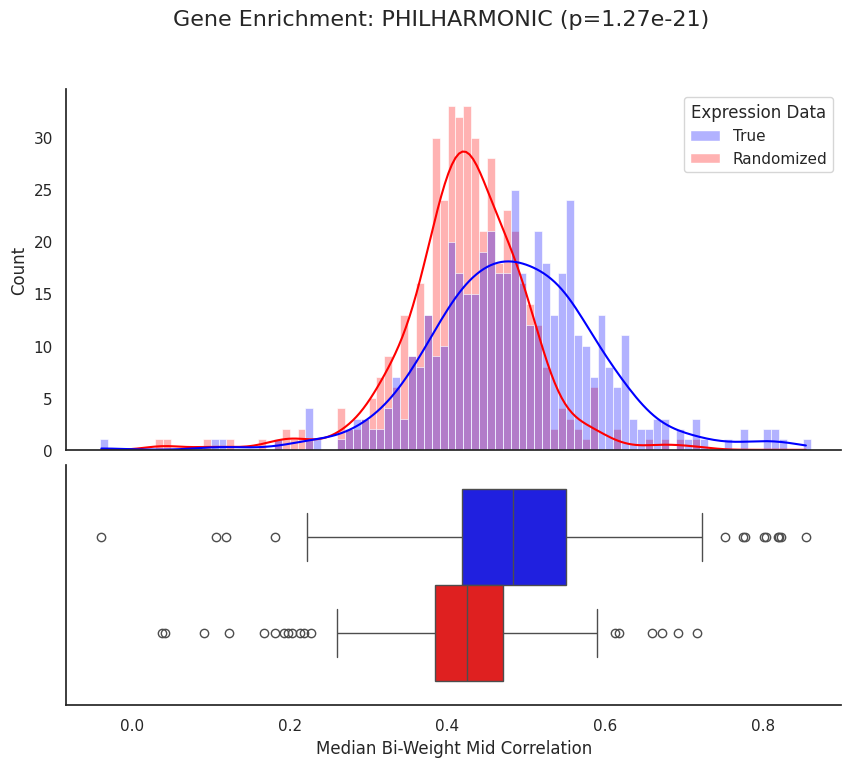

In [15]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

tstat_rand, p_rand = ttest_rel(
    cluster_corr_df["True"], cluster_corr_df["Randomized"], alternative="greater"
)

plot_df = cluster_corr_df.melt("key").rename(
    {"value": "Median Bi-Weight Mid Correlation", "variable": "Expression Data"}, axis=1
)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=plot_df,
    x="Median Bi-Weight Mid Correlation",
    hue="Expression Data",
    alpha=0.3,
    kde=True,
    bins=np.arange(-0.1, 1.05, 0.01),
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0,
)

sns.boxplot(
    data=cluster_corr_df.melt("key"),
    x="value",
    hue="variable",
    palette=["blue", "red"],
    ax=ax1,
)

ax0.set_xlabel("")  # Remove x-label from top plot
ax1.set_xlabel("Median Bi-Weight Mid Correlation")  # Add x-label to bottom plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot


ax0.set_xlim(ax1.get_xlim())  # Align the x-axis of both subplots
ax1.get_legend().remove()  # Remove legend from bottom plot

plt.suptitle(f"Gene Enrichment: PHILHARMONIC (p={p_rand:.3})", fontsize=16)

# Show the plot
sns.despine()
plt.savefig(IMG_DIR / "gexp_enrichment_combined.svg", bbox_inches="tight", dpi=300)
plt.show()

---

# Validate Clusters with Gene Expression Gene Programs

In [17]:
dense_df.head()

,Hw1-1a,Hw1-1b,Hw1-1c,Hw1-4a,Hw1-4b,Hw1-4c,Hw1-5a,Hw1-5b,Hw1-5c,Hw1-6a,...,Wt2-1c,Wt2-4a,Wt2-4b,Wt2-4c,Wt2-5a,Wt2-5b,Wt2-5c,Wt2-6a,Wt2-6b,Wt2-6c
Geneid,,,,,,,,,,,,,,,,,,,,,
pdam_00021773-RA,292,72,77,26,8,37,353,51,271,380,...,6,5,34,16,30,23,2,28,13,25
pdam_00021770-RA,129,214,147,163,181,250,286,386,341,268,...,201,236,440,492,366,340,213,441,380,347
pdam_00021774-RA,60,27,31,44,47,62,43,108,107,67,...,14,26,61,64,86,50,34,86,64,55
pdam_00021772-RA,55,61,76,69,86,67,128,108,132,130,...,116,84,150,215,169,222,109,191,162,154
pdam_00021771-RA,30,29,29,30,23,21,60,48,43,46,...,35,32,64,74,40,59,28,60,41,53


In [33]:
def extract_cluster_ranks(
    cluster_members, dense_df, normalize_cluster_size = True
):
    """
    Extract the the rank of the expression matrix for a set of genes.

    Parameters:
    cluster_members (list): A list of gene names
    correlation_df (pd.DataFrame): A DataFrame containing pairwise correlations

    Returns:
    pd.DataFrame: A DataFrame containing pairwise correlations for the input genes
    """
    members = list(set(cluster_members).intersection(dense_df.index))
    sub_expr_df = dense_df.loc[list(set(members).intersection(dense_df.index))]
    cluster_rank = np.linalg.matrix_rank(sub_expr_df.values)
    if normalize_cluster_size:
        cluster_rank = cluster_rank / len(members)
    return cluster_rank

def extract_cluster_singular_values(
    cluster_members, dense_df, return_vector = False
):
    """
    Extract the the rank of the expression matrix for a set of genes.

    Parameters:
    cluster_members (list): A list of gene names
    correlation_df (pd.DataFrame): A DataFrame containing pairwise correlations

    Returns:
    pd.DataFrame: A DataFrame containing pairwise correlations for the input genes
    """
    members = list(set(cluster_members).intersection(dense_df.index))
    sub_expr_df = dense_df.loc[list(set(members).intersection(dense_df.index))]
    cluster_svdvals = np.linalg.svdvals(sub_expr_df.values)
    if return_vector:
        return cluster_svdvals
    else:
        return cluster_svdvals[0] / cluster_svdvals.sum()

def resample_expression_matrix(expression_df, random_seed=42):
    """
    Randomly re-order the row and column names and reassign them to a correlation matrix.
    """
    from copy import deepcopy

    new_df = deepcopy(expression_df)
    rng = np.random.default_rng(random_seed)
    new_prot_order = rng.permutation(new_df.index)
    new_df.index = new_prot_order
    return new_df

In [39]:
rand_expression_df = resample_expression_matrix(dense_corr_df)

rand_rank_df = pd.DataFrame(
    {
        "key": cluster_dict.keys(),
        "True": [
            extract_cluster_singular_values(
                c["members"] + list(c["recipe"]["degree"]["0.75"]),
                dense_corr_df,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
        "Randomized": [
            extract_cluster_singular_values(
                c["members"] + list(c["recipe"]["degree"]["0.75"]),
                rand_expression_df,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
    }
)

100%|██████████| 468/468 [02:57<00:00,  2.64it/s]


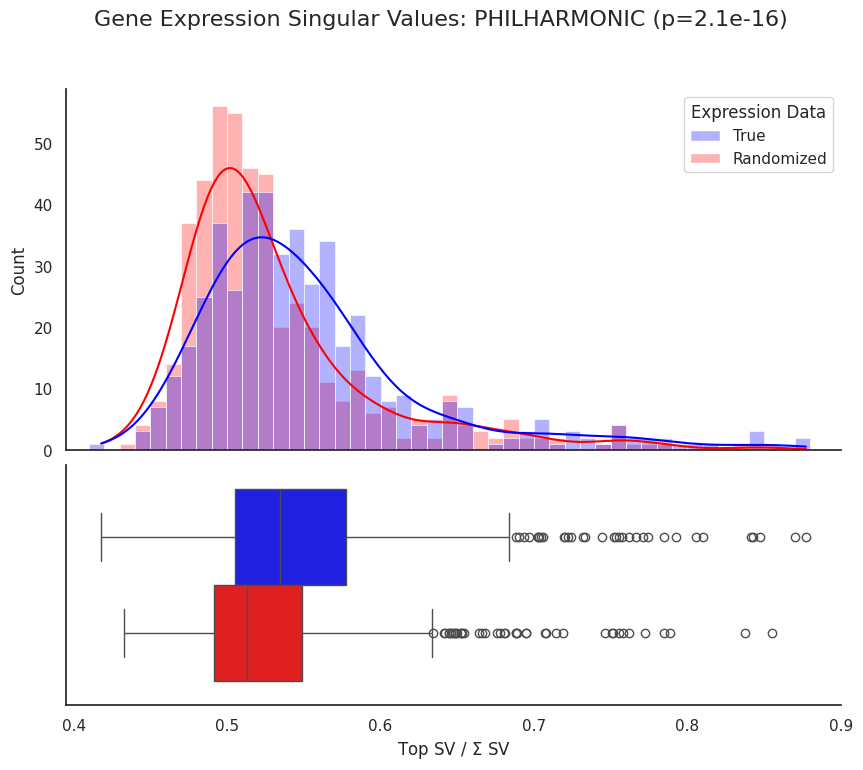

In [43]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

tstat_rand, p_rand = ttest_rel(
    rand_rank_df["True"], rand_rank_df["Randomized"], alternative="greater"
)

plot_df = rand_rank_df.melt("key").rename(
    {"value": "Rank", "variable": "Expression Data"}, axis=1
)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=plot_df,
    x="Rank",
    hue="Expression Data",
    alpha=0.3,
    kde=True,
    bins=np.arange(-0.1, 1.05, 0.01),
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0,
)

sns.boxplot(
    data=rand_rank_df.melt("key"),
    x="value",
    hue="variable",
    palette=["blue", "red"],
    ax=ax1,
)

ax0.set_xlabel("")  # Remove x-label from top plot
ax1.set_xlabel(r"Top SV / $\Sigma$ SV")  # Add x-label to bottom plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot


ax0.set_xlim(ax1.get_xlim())  # Align the x-axis of both subplots
ax1.get_legend().remove()  # Remove legend from bottom plot

plt.suptitle(f"Gene Expression Singular Values: PHILHARMONIC (p={p_rand:.3})", fontsize=16)

# Show the plot
sns.despine()
plt.savefig(IMG_DIR / "gexp_sv_ratios.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## Export Differential Expression for Cytoscape

In [14]:
philharmonic_prots = set.union(
    *[set(c["members"]) for c in cluster_dict.values()]
).intersection(deg_df.index)
prot_deg_cytoscape_table_df = deg_df.loc[
    list(philharmonic_prots),
    [
        "log2FoldChange_Heat_control",
        "log2FoldChange_Antibiotics_control",
        "log2FoldChange_Antibiotics.Heat_control",
    ],
]

logger.info(f"Writing {len(philharmonic_prots)} entries to {prot_deg_cytoscape_table}")
prot_deg_cytoscape_table_df.to_csv(prot_deg_cytoscape_table, sep="\t")

2024-10-21 10:56:50.134 | INFO     | __main__:<module>:13 - Writing 4235 entries to /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_proteins.deg.tsv


In [15]:
conditions = ["Heat_control", "Antibiotics_control", "Antibiotics.Heat_control"]
p_thresh = 0.05

cluster_de_df = []

for k, cl in tqdm(cluster_dict.items(), total=len(cluster_dict)):
    cluster_members = list(set(cl["members"]).intersection(deg_df.index))
    diffexp_df = deg_df.loc[cluster_members]
    cluster_row = [k]

    for cond in conditions:
        # log2FoldChange
        if len(diffexp_df):
            cluster_row.append(np.mean(diffexp_df[f"log2FoldChange_{cond}"]))
        else:
            cluster_row.append(np.nan)
        # padj
        cluster_row.append(np.sum(diffexp_df[f"padj_{cond}"] < p_thresh))
        # DE_Up
        cluster_row.append(np.sum(diffexp_df[f"DE_{cond}"] == "Upregulated"))
        # DE_Down
        cluster_row.append(np.sum(diffexp_df[f"DE_{cond}"] == "Downregulated"))
    cluster_de_df.append(cluster_row)

cluster_de_df = pd.DataFrame(cluster_de_df)
cluster_de_df.columns = ["key"] + [
    f"{j}_{i}"
    for i, j in product(conditions, ["log2FoldChange", "padj", "DE_Up", "DE_Down"])
]
cluster_de_df = cluster_de_df.set_index("key")

100%|██████████| 468/468 [00:00<00:00, 786.54it/s]


In [16]:
cluster_de_df.head()
cluster_de_df.to_csv(clust_deg_cytoscape_table, sep="\t")
logger.info(f"Writing {len(cluster_de_df)} entries to {clust_deg_cytoscape_table}")

2024-10-21 10:56:50.769 | INFO     | __main__:<module>:3 - Writing 468 entries to /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.deg.tsv
